# NLP Visualizations

In [2]:
!aws s3 ls


2023-08-29 23:43:16 sagemaker-studio-692960231031-wo7kgoszj2g
2023-08-29 23:50:01 sagemaker-us-east-1-692960231031
2023-08-30 00:34:21 vad49
2023-09-16 16:02:10 vad49-labdata


In [3]:
!aws s3 ls s3://project17-bucket-alex/stories-and-books-nlp/


                           PRE mapping/
                           PRE processed-data/


In [4]:
if True is True: # set to true only for the first un
    # Setup - Run only once per Kernel App
    %conda install openjdk -y

    # install PySpark
    %pip install pyspark==3.2.0 s3fs pyarrow

    # restart kernel
    from IPython.core.display import HTML
    HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.7.22          |  py310h06a4308_0         153 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [5]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions as F
from pyspark.sql.functions import col, length, isnan, when, count, regexp_extract, weekofyear, hour, avg, to_date, unix_timestamp, lit, corr, size, explode, udf
from pyspark.ml.feature import NGram

from pyspark.sql.types import StringType

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import boto3
import pickle
from io import BytesIO

pd.set_option('display.max_colwidth', 150) 
#pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)


In [6]:
# Import pyspark and build Spark session

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    #.config("spark-jars-packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3")\
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-94bf993a-d56d-4526-be95-62198061ba64;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 378ms :: artifacts dl 32ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

3.2.0


In [7]:
# read in the data

all_model_text = spark.read.parquet("s3a://project17-bucket-alex/stories-and-books-nlp/processed-data/")

display(f"shape: ({all_model_text.count()}, {len(all_model_text.columns)})")
all_model_text.show()

23/11/19 14:31:18 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


'shape: (12161, 3)'

+--------------------+--------------------+--------------------+
|                text|       custom_tokens|         text_as_int|
+--------------------+--------------------+--------------------+
|First of all, I n...|[first,  , of,  ,...|[22, 25, 34, 35, ...|
|I started a job a...|[i,  , started,  ...|[25, 1, 35, 36, 1...|
|My older brother ...|[my,  , older,  ,...|[29, 41, 1, 31, 2...|
|When I was a kid,...|[when,  , i,  , w...|[39, 24, 21, 30, ...|
|TL/DR on bottom!\...|[tldr,  , on,  , ...|[36, 28, 20, 34, ...|
|I have many stori...|[i,  , have,  , m...|[25, 1, 24, 17, 3...|
| \n\nFaults in Ma...|[ , faults,  , in...|[1, 22, 17, 37, 2...|
|My (24F) boyfrien...|[my,  , 24f,  , b...|[29, 41, 1, 7, 9,...|
|So, this wasn't r...|[so, ,,  , this, ...|[35, 31, 3, 1, 36...|
|\nEDIT: Hi! Still...|[edit,  , hi, !, ...|[21, 20, 25, 36, ...|
|tl;dr: So basical...|[tl, ;, dr,  , so...|[36, 28, 15, 20, ...|
|Obligatory, I mis...|[obligatory, ,,  ...|[31, 18, 28, 25, ...|
|Warning: mentions...|[wa

In [8]:
# bring in mapping

s3 = boto3.client('s3')

bucket_name = 'project17-bucket-alex'
object_key = 'stories-and-books-nlp/mapping/char2idx.pkl'

char2idx_buffer = BytesIO()

s3.download_fileobj(bucket_name, object_key, char2idx_buffer)

char2idx_buffer.seek(0)

# define
char2idx = pickle.load(char2idx_buffer)

# define the reverse too
idx2char = {idx: char for char, idx in char2idx.items()}


### Token frequency

In [9]:

# convert token index to character
def index_to_char(index):
    return idx2char.get(index, '')  # Returns an empty string if the index is not found


index_to_char_udf = udf(index_to_char, StringType())

# use characters instead of indices
token_freq = all_model_text.withColumn('token', explode('text_as_int')) \
                           .withColumn('character', index_to_char_udf(col('token'))) \
                           .groupBy('character').count().orderBy('count', ascending=False)



# top 10
top_10_token_freq = token_freq.limit(10)

# convert to pandas
top_10_token_freq_pd = top_10_token_freq.toPandas()

# save
top_10_token_freq_pd.to_csv("../../data/nlp-data/books-and-stories-token-frequency.csv", index=False)

display(top_10_token_freq_pd)



,character,count
0,,5615570
1,e,2824980
2,t,2202938
3,a,1887150
4,o,1785250
5,i,1712068
6,n,1586710
7,s,1439350
8,h,1323594
9,r,1203837


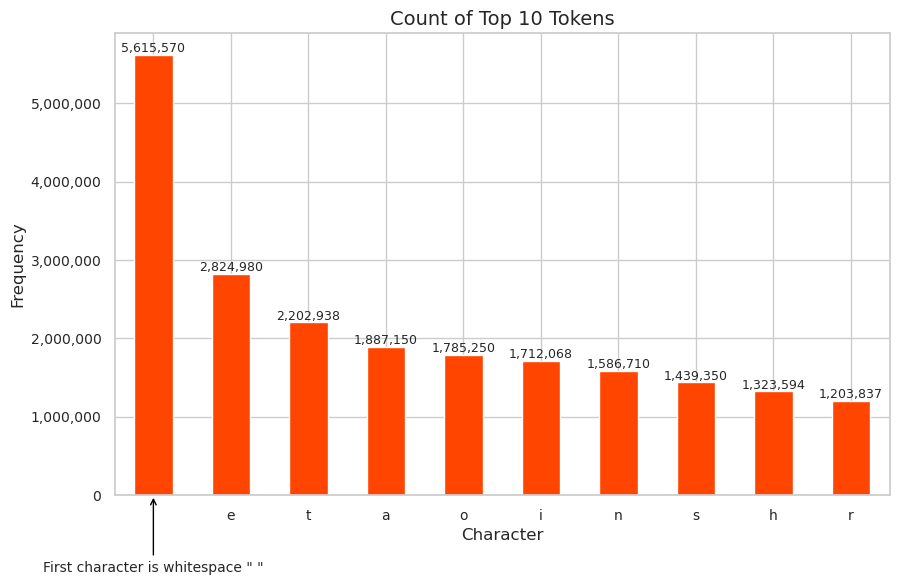

In [35]:

# style
sns.set(style="whitegrid")


# init plot
ax = top_10_token_freq_pd.head(20).plot(
    kind='bar',
    x='character',
    y='count',
    color='#ff4500',
    figsize=(10, 6),
    legend=False
)

# add text
plt.title('Count of Top 10 Tokens', fontsize=14)
plt.xlabel('Character', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)



# create annotation for whitespace
plt.annotate('First character is whitespace " "', 
             xy=(0, 0), xycoords='data',
             xytext=(0, fixed_negative_offset), textcoords='data', 
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='black'),
             fontsize=10, ha='center', va='top')


# off scientific notation
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))



# add labels
for index, value in enumerate(top_10_token_freq_pd.head(20)['count']):
    plt.text(index, value, f'{value:,.0f}', ha='center', va='bottom', fontsize=9)

    
# save and show
plt.savefig('../../website-source/img/nlp-plots/books-and-stories-token-frequency-plot.png', bbox_inches='tight')
plt.show()


### N-Gram Analysis

In [28]:
# define n grams
ngram = NGram(n=5, inputCol="custom_tokens", outputCol="ngrams")
ngram_df = ngram.transform(all_model_text)
ngram_freq = ngram_df.withColumn('ngram', explode('ngrams')).groupBy('ngram').count().orderBy('count', ascending=False)


# top 10
top_10_ngrams = ngram_freq.limit(10)

# convert to pandas and save
top_10_pd = top_10_ngrams.toPandas()
top_10_pd.to_csv("../../data/nlp-data/books-and-stories-n-grams.csv", index=False)

display(top_10_pd)


23/11/18 22:29:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/18 22:30:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/18 22:30:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


,ngram,count
0,i was,22165
1,and i,17933
2,in the,15264
3,of the,13807
4,that i,11631
5,to be,10346
6,it was,10172
7,to the,9418
8,i had,8307
9,i dont,8212
